In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import joblib
import time
from utils import *

In [2]:
pd.set_option('display.max_columns', None) # show all columns of a data frame

In [3]:
parent_dir = os.path.dirname(os.getcwd())
train_file = os.path.join(parent_dir, 'CMAPSS_Data', 'train_FD001.txt')
test_file = os.path.join(parent_dir, 'CMAPSS_Data', 'test_FD001.txt')
rul_file = os.path.join(parent_dir, 'CMAPSS_Data','RUL_FD001.txt')
weight_path = os.path.join(parent_dir, 'weights')

In [4]:
raw_train_df = pd.read_csv(train_file, sep=r"\s+", header=None)
raw_test_df = pd.read_csv(test_file, sep=r"\s+", header=None)
rul_df = pd.read_csv(rul_file, sep=r"\s+", header=None)
print(raw_train_df.shape)
print(raw_test_df.shape)

(20631, 26)
(13096, 26)


In [5]:
columns = ['unit_number','time_in_cycles','op_set_1','op_set_2','op_set_3','sm_1','sm_2','sm_3','sm_4','sm_5','sm_6','sm_7',
           'sm_8','sm_9','sm_10','sm_11','sm_12','sm_13','sm_14','sm_15','sm_16','sm_17','sm_18','sm_19','sm_20','sm_21']
raw_train_df.columns = columns
raw_test_df.columns = columns
rul_df.columns = ['rul']

In [6]:
raw_train_df.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
unit_number_train = pd.DataFrame({'unit_number' : raw_train_df['unit_number']})
unit_number_test = pd.DataFrame({'unit_number' : raw_test_df['unit_number']})

In [8]:
train_df = prepare_train_dataset(raw_train_df)
print(train_df.shape)
train_df.head()

(20631, 16)


,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,rul
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [9]:
test_df = prepare_test_dataset(raw_test_df)
print(test_df.shape)
test_df.head()

(100, 15)


,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,31,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


### Create classification labels
RUL less than 20 : 0  
RUL between 20 and 50 : 1  
RUL greater than 50 : 2

In [10]:
y_train = np.ones(train_df.shape[0], dtype=np.uint8)
y_test = np.ones(test_df.shape[0], dtype=np.uint8)

In [11]:
y_train[train_df['rul'] > 50] = 2
y_train[train_df['rul'] < 20] = 0
y_test[rul_df['rul'] > 50] = 2
y_test[rul_df['rul'] < 20] = 0

In [12]:
# print(sum(train_df['rul'] > 50))
# print(sum(train_df['rul'] < 20))
# print(np.unique(train_labels, return_counts=True))

In [13]:
X_train = train_df.iloc[:, :-1].to_numpy()
X_test = test_df.to_numpy()
print(X_train.shape)
print(X_test.shape)

(20631, 15)
(100, 15)


### Using Random Forest Classifier

In [14]:
random_forest=RandomForestClassifier(n_estimators=110, n_jobs=-1, random_state=1)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [15]:
y_rf_pred = random_forest.predict(X_test)

In [16]:
conf_mat = confusion_matrix(y_test, y_rf_pred)
clf_report = classification_report(y_test, y_rf_pred)

In [17]:
print("Accuracy = %0.4f" % accuracy_score(y_test, y_rf_pred))
print("Classification report")
print(clf_report)

Accuracy = 0.8800
Classification report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        13
           1       0.74      0.70      0.72        20
           2       0.93      0.94      0.93        67

    accuracy                           0.88       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.88      0.88      0.88       100



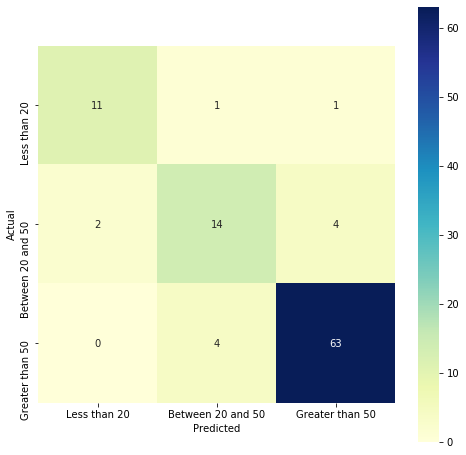

In [18]:
fig, ax = plt.subplots(figsize=(8,8))         
ax = sns.heatmap(conf_mat, annot=True, fmt='d', square=True, cmap="YlGnBu", 
                 xticklabels=['Less than 20', 'Between 20 and 50', 'Greater than 50'], 
                 yticklabels=['Less than 20', 'Between 20 and 50', 'Greater than 50'])
               
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
joblib.dump(random_forest, os.path.join(weight_path, 'random_forest_classif.sav'))

['D:\\Projects\\machine_failure\\weights\\random_forest_classif.sav']

### Using XGBoost Classifier

In [20]:
xgb = XGBClassifier(n_estimators=110, n_jobs=-1, random_state=1, verbosity=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=110, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
y_xgb_pred = xgb.predict(X_test)

In [22]:
conf_mat = confusion_matrix(y_test, y_xgb_pred)
clf_report = classification_report(y_test, y_xgb_pred)

In [23]:
print("Accuracy = %0.4f" % accuracy_score(y_test, y_xgb_pred))
print("Classification report")
print(clf_report)

Accuracy = 0.8800
Classification report
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.74      0.70      0.72        20
           2       0.94      0.96      0.95        67

    accuracy                           0.88       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.88      0.88      0.88       100



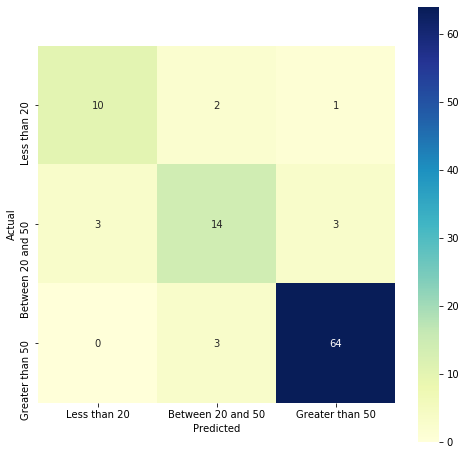

In [24]:
fig, ax = plt.subplots(figsize=(8,8))         
ax = sns.heatmap(conf_mat, annot=True, fmt='d', square=True, cmap="YlGnBu", 
                 xticklabels=['Less than 20', 'Between 20 and 50', 'Greater than 50'], 
                 yticklabels=['Less than 20', 'Between 20 and 50', 'Greater than 50'])
               
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
joblib.dump(xgb, os.path.join(weight_path, 'xgb_classif.sav'))

['D:\\Projects\\machine_failure\\weights\\xgb_classif.sav']